In [1]:
import sys
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdftypes import resolve1
from fpdf import FPDF
import json
import pandas as pd
import os
import matplotlib.pyplot as plt 

In [2]:
folder_list= next(os.walk('.'))[1]
folder_list= folder_list[1:]

In [3]:
folder_list

['Guilherme', 'Mr. Stevan', 'sudhanshu']

In [4]:
location= os.path.join(os.curdir, "Guilherme")
location

'.\\Guilherme'

In [5]:
location+"\hw1.pdf"

'.\\Guilherme\\hw1.pdf'

In [10]:
def feedback_generator(output, location):
    pdf = FPDF()
    pdf.set_font("Arial", size=12)
    pdf.add_page()
    for key in output:
        # cell with 0 width and 10 height
        # ln=1 is for line break
        pdf.cell(0, 10, txt="{0} : {1}".format(key, output[key]), ln=1, align= 'C')
    pdf.output(location+ "\\Feedback.pdf")

In [24]:
row_list= []
mcq= 0
mcq_wrong= 0

ans_df= pd.read_csv("answer.csv")
ans_df.set_index('Name', inplace=True)

with open("file_info.txt", 'r') as f:
    file_name= f.readline()

for folder in folder_list:
    model_ans= {}
    for column in ans_df.columns:
        model_ans[column]= ans_df.loc[folder, column]
    
    i=0
    location= os.path.join(os.curdir, folder)
    fp = open(location+"\\"+file_name, 'rb')

    parser = PDFParser(fp)
    doc = PDFDocument(parser)
    fields = resolve1(doc.catalog['AcroForm'])['Fields']
    given_ans= {}
    quest_type= {}
    for i in fields:
        field = resolve1(i)
        name, value = field.get('T'), field.get('V')
        name= name.decode('utf-8')
        temp= str(value)
        if(temp== "b''"):
            value= "null"
            quest_type[name]= 'numerical'
        elif(temp== "/'null'"):
            value= "null"
            quest_type[name]= 'mcq'
        else:
            if(temp[0] == "b"):
                quest_type[name]= 'numerical'
                value= float(value.decode('utf-8'))
            else:
                quest_type[name]= 'mcq'
                value= temp[2]
    #     print ('{0}: {1}'.format(name, value))
        given_ans[name]= value
        print(value)
    fp.close()
    
    output= {}
    marks= {}
    for key in given_ans:
        if(given_ans[key] == "null"):
            output[key]= "You have not written any answer for this question."
            marks[key]= -1
        elif(type(given_ans[key])== float):  
            # this for the negative answers, for negative ans the comparison operator reverses so made absolute
            tmp_given_ans= given_ans[key]
            tmp_model_ans= model_ans[key]
            given_ans[key]= abs(given_ans[key])
            model_ans[key]= abs(model_ans[key])
        
            if(tmp_given_ans== tmp_model_ans):
                output[key]= "Your answer is exactly correct. Hurray !!!"
                marks[key]= 1
            elif(given_ans[key]<= 1.05*model_ans[key] and given_ans[key]>= 0.95*model_ans[key]):
                output[key]= "Your answer is within 5 percent range of the model answer. You got Full marks for this question !!"
                marks[key]= 0.95
            elif(given_ans[key]<= 1.1*model_ans[key] and given_ans[key]>= 0.9*model_ans[key]):
                output[key]= "Your answer is within 10 percent range of the model answer. You got Half marks for this question."
                marks[key]= 0.5
            elif(given_ans[key]<= 1.25*model_ans[key] and given_ans[key]>= 0.75*model_ans[key]):
                output[key]= "Your answer is within 25 percent range of the model answer. You got Quarter marks for this question"
                marks[key]= 0.25
            else:
                output[key]= "Your answer has more than 25 percent error. Please correct it."
                marks[key]= 0
        else:
            if(given_ans[key] == model_ans[key]):
                output[key]= "Your answer is exactly correct. Hurray !!!"
                marks[key]= 1
                mcq+=1
            else:
                output[key]= "Your answer is Wrong. Please understand it."
                marks[key]= 0
                mcq_wrong+=1
     

    marks['Name']= folder
    row_list.append(marks)
    
    feedback_generator(output, location)

null
55.0
null
20.0
15.0
a
40.0
30.0
c
-58.0
4.0
d
35.0
22.0
b
55.0
64.0
a


In [25]:
row_list

[{'Name': 'Guilherme',
  'quest1': -1,
  'quest2': 0.5,
  'quest3': -1,
  'quest4': 0,
  'quest5': 0.25,
  'quest6': 1},
 {'Name': 'Mr. Stevan',
  'quest1': 0.25,
  'quest2': 0.25,
  'quest3': 0,
  'quest4': 0.95,
  'quest5': 0,
  'quest6': 1},
 {'Name': 'sudhanshu',
  'quest1': 0.25,
  'quest2': 0.5,
  'quest3': 0,
  'quest4': 1,
  'quest5': 0,
  'quest6': 1}]

In [26]:
cols= list(given_ans.keys())
cols.insert(0, "Name")
df= pd.DataFrame(row_list)
df.set_index('Name', inplace= True)
df.head()

,quest1,quest2,quest3,quest4,quest5,quest6
Name,,,,,,
Guilherme,-1.00,0.50,-1,0.00,0.25,1
Mr. Stevan,0.25,0.25,0,0.95,0.00,1
sudhanshu,0.25,0.50,0,1.00,0.00,1


In [14]:
df.to_csv("final_report.csv")

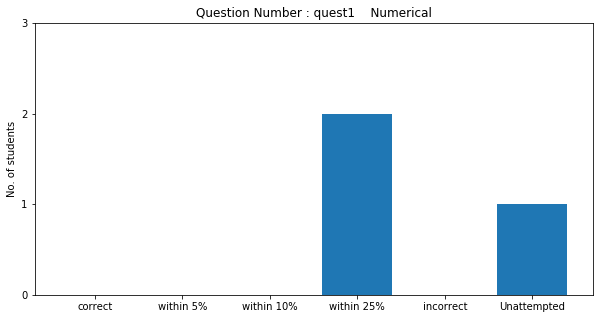

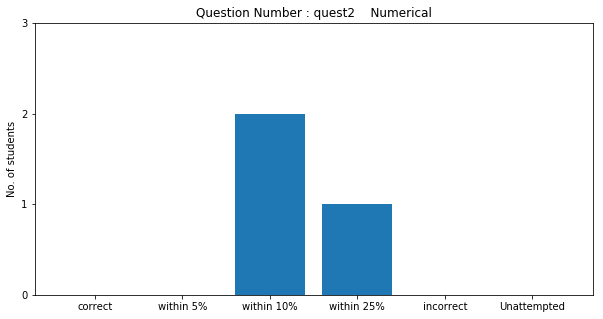

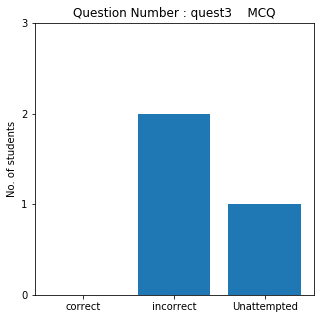

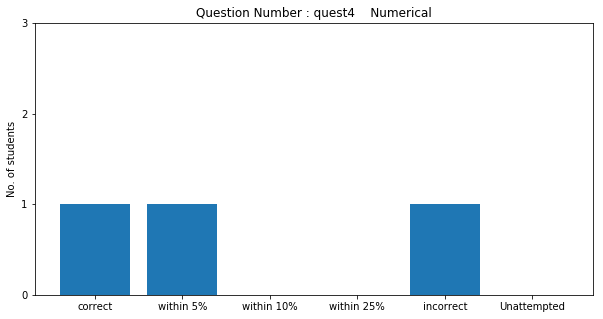

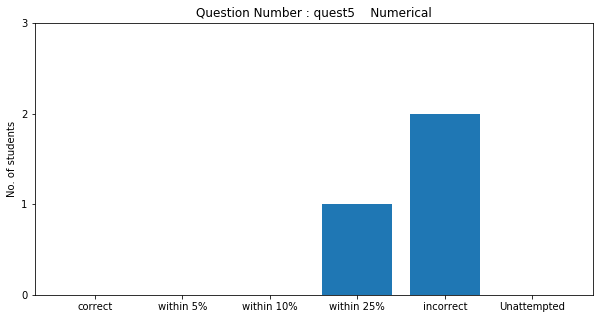

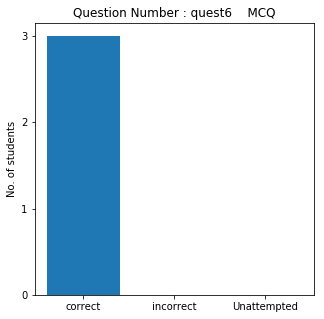

In [30]:
for column in df.columns:
    total_std= len(df)
    marks_list= list(df[column].values)
    if(quest_type[column]== 'numerical'):
        num= len(df[df[column] == 1])
        num_5= len(df[df[column] == 0.95])
        num_10= len(df[df[column] == 0.5])
        num_25= len(df[df[column] == 0.25])
        num_wrong= len(df[df[column] == 0])
        num_left= len(df[df[column] == -1])
        x=[0, 1, 2, 3, 4, 5]
        plt.figure(figsize= (10,5))
        plt.bar(x, height= [num, num_5, num_10, num_25, num_wrong, num_left])
        plt.xticks(x, ['correct', 'within 5%', 'within 10%', 'within 25%', 'incorrect', 'Unattempted'])
        plt.ylabel('No. of students')
        plt.yticks(range(0, total_std+1))
        plt.title("Question Number : "+ str(column)+ "    Numerical")
        plt.show()
    else:
        mcq= len(df[df[column] == 1])
        mcq_wrong= len(df[df[column] == 0])
        mcq_left= len(df[df[column] == -1])
        x=[0, 1, 2]
        plt.figure(figsize= (5,5))
        plt.bar(x, height= [mcq, mcq_wrong, mcq_left])
        plt.xticks(x, ['correct', 'incorrect', 'Unattempted'])
        plt.ylabel('No. of students')
        plt.yticks(range(0, total_std+1))
        plt.title("Question Number : "+ str(column)+ "    MCQ")
        plt.show()

In [49]:
yint= range(0, 7)

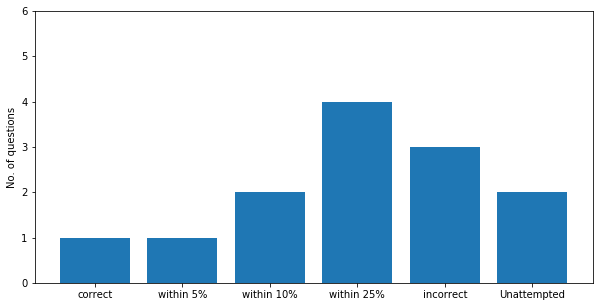

In [62]:
x=[0, 1, 2, 3, 4, 5]
plt.figure(figsize= (10,5))
plt.bar(x, height= [num, num_5, num_10, num_25, num_wrong, num_left])
plt.xticks(x, ['correct', 'within 5%', 'within 10%', 'within 25%', 'incorrect', 'Unattempted'])
plt.ylabel('No. of students')
plt.yticks(yint)
plt.show()

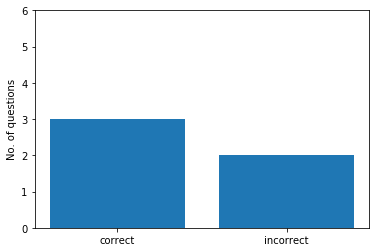

In [29]:
x=[0, 1]
plt.bar(x, height= [mcq, mcq_wrong])
plt.xticks(x, ['correct', 'incorrect'])
plt.ylabel('No. of students')
plt.yticks(yint)
plt.show()